In [55]:
import os

from sqlalchemy import create_engine, text
import pandas as pd
from dotenv import load_dotenv

load_dotenv("../.env")


In [ ]:
METRICS_USER = os.environ["METRICS_USER"]
METRICS_PASSWORD = os.environ["METRICS_PASSWORD"]
METRICS_HOSTNAME = os.environ["METRICS_HOSTNAME"]
METRICS_PORT = os.environ["METRICS_PORT"]
METRICS_DB = os.environ["METRICS_DB"]

In [ ]:
engine = create_engine(
    f"postgresql://{METRICS_USER}:{METRICS_PASSWORD}@{METRICS_HOSTNAME}:{METRICS_PORT}/{METRICS_DB}"
)

# TMP

In [56]:

def default_metrics_extraction(query: str ):
    with engine.connect() as connection:
        df_raw = pd.read_sql_query(text(query), connection)
    return df_raw

In [8]:
bdp = default_metrics_extraction("""
                WITH unpacked AS (
                    SELECT
                        bdp._id as metrics_id,
                        id as bdp_id,
                        bdp_rq.reference,
                        bdp_sd.start as storage_datetime,
                        bdp_sd."end" as ausgabe_datetime,
                        jsonb_array_elements(bdp.extension) as ext,
                        bdp_pro.display as display,
                        bdp_pro.code as code
                    FROM
                        biologicallyderivedproduct bdp
                    JOIN
                        biologicallyderivedproduct_request bdp_rq ON bdp_rq._resource = bdp._id
                    JOIN
                        biologicallyderivedproduct_storage_duration bdp_sd ON bdp_sd._resource = bdp._id
                    JOIN
                        "biologicallyderivedproduct_productCode_coding" bdp_pro on bdp_pro._resource = bdp._id

                ),
                filtered AS (
                    SELECT
                        metrics_id,
                        bdp_id,
                        replace(reference, 'ServiceRequest/', '') as service_request_id,
                        lower(storage_datetime) as storage_datetime,
                        lower(ausgabe_datetime) as ausgabe_datetime,
                        display,
                        code,
                        CASE
                            WHEN ext->>'url' = 'https://uk-essen.de/LAB/Nexus/Swisslab/KONSERVE/VERBRAUCH' THEN ext->>'valueString'
                            ELSE NULL
                        END as verbrauch,
                        CASE
                            WHEN ext->>'url' = 'https://uk-essen.de/LAB/Nexus/Swisslab/KONSERVE/AUSGABEAN' THEN ext->>'valueString'
                            ELSE NULL
                        END as ausgabean
                    FROM unpacked
                    WHERE ext->>'url' IN ('https://uk-essen.de/LAB/Nexus/Swisslab/KONSERVE/VERBRAUCH', 'https://uk-essen.de/LAB/Nexus/Swisslab/KONSERVE/AUSGABEAN')
                )
                SELECT
                    metrics_id,
                    bdp_id,
                    service_request_id,
                    storage_datetime,
                    ausgabe_datetime,
                    MAX(verbrauch) as verbrauch,
                    MAX(ausgabean) as ausgabean,
                    display,
                    code
                FROM filtered
                GROUP BY metrics_id, bdp_id, service_request_id, storage_datetime, ausgabe_datetime, display, code"""
)

In [63]:
bdp.drop_duplicates(subset=["metrics_id", "bdp_id"], inplace=True)
bdp_filtered = bdp[
    (bdp["ausgabe_datetime"] >= '2021-03-01')
    & (bdp["ausgabe_datetime"] <= '2021-03-30')
]

sr_ids = "', '".join(bdp_filtered["service_request_id"].unique())

In [64]:
sr = default_metrics_extraction(f"""
            SELECT
                id as service_request_id,
                replace(sr_sub.reference, 'Patient/', '') as patient_id,
                fhirql_read_codes(status) as status,
                fhirql_read_codes(priority) as priority
            FROM servicerequest
            JOIN servicerequest_subject sr_sub on sr_sub._resource = servicerequest._id
            WHERE id in ('{sr_ids}')""")


In [65]:
bdp_filtered = pd.merge(bdp_filtered, sr, on="service_request_id", how="left")

In [66]:
bdp_filtered.isna().sum()

metrics_id            0
bdp_id                0
service_request_id    0
storage_datetime      0
ausgabe_datetime      0
verbrauch             0
ausgabean             0
display               0
code                  0
patient_id            0
status                0
priority              0
dtype: int64

In [67]:
sr.columns

Index(['service_request_id', 'patient_id', 'status', 'priority'], dtype='object')

In [68]:
bdp_filtered.columns

Index(['metrics_id', 'bdp_id', 'service_request_id', 'storage_datetime',
       'ausgabe_datetime', 'verbrauch', 'ausgabean', 'display', 'code',
       'patient_id', 'status', 'priority'],
      dtype='object')

In [74]:
bdp_filtered['date'] = pd.to_datetime(bdp_filtered['ausgabe_datetime']).dt.date
bdp_filtered['priority'] = [x[0] for x in bdp_filtered['priority']]

In [75]:
grouped = bdp_filtered.groupby(["date", "priority"]).size().reset_index(name="count")

In [76]:
# only plot routine 
grouped_routine = grouped[grouped["priority"] == "routine"]

<Axes: xlabel='date'>

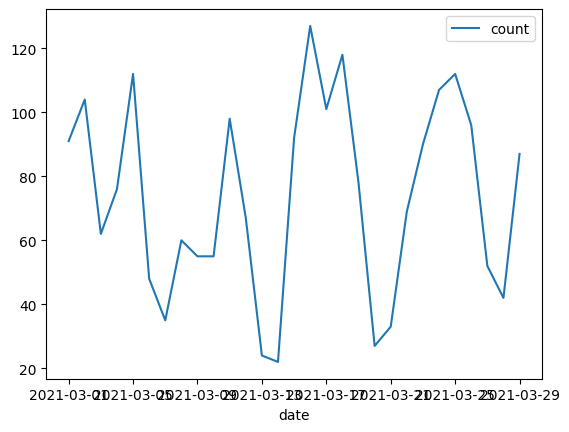

In [79]:
from matplotlib import pyplot as plt
grouped_routine.plot(x="date", y="count")

<Axes: xlabel='date'>

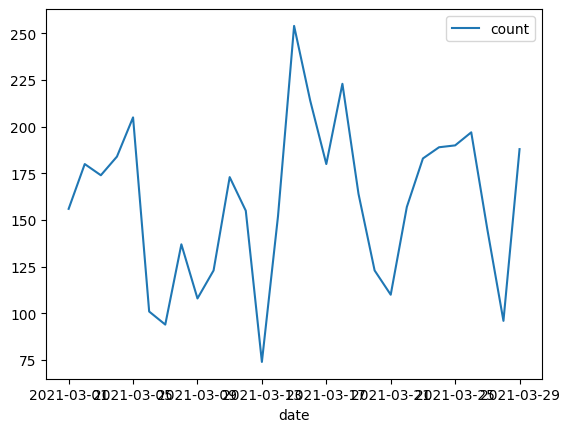

In [86]:
grouped_all = bdp_filtered.groupby(["date"]).size().reset_index(name="count")
grouped_all.plot(x="date", y="count")


In [87]:
bdp = pd.read_pickle('/local/work/merengelke/fhir_former/testing_30d/data_raw/biologically_derived_product.pkl')

In [88]:
bdp

,metrics_id,bdp_id,service_request_id,storage_datetime,ausgabe_datetime,verbrauch,ausgabean,display,code,patient_id,status,priority
0,1627467,0005f60c9cdc9e992f64d678db8998bb32a614a87b1095...,b2fbf9986ddbfadbc13c72fa7d4e6b6cc0806538687ffd...,2021-02-27 09:50:00+00:00,2021-03-16 09:11:00+00:00,AUSGABE,R-S4,Blood derivative product (product),133,fee8b2d33c91455af8a6eb7af5ebd2886655d7b182f00a...,[revoked],[urgent]
1,1628109,0020428e80074283ebb30fcfd5f3b4e235f5e7a3b0a45c...,fcb1374c840418d8c3a21d789fd6bc8a0d6e18cf73ba75...,2021-03-03 13:32:00+00:00,2021-03-17 07:15:00+00:00,AUSGABE,HZ3,Blood derivative product (product),133,fdfc12c2f64bfc0f56986612d44b5d48e554fb494c1188...,[revoked],[routine]
2,1628256,0026435856ea0b9e7ad1b0c8d7577309df5ab15af5bbe8...,a093ebc90a2751049817fd06f0e67aec42b1f092b06e6f...,2021-02-12 10:50:00+00:00,2021-03-12 10:45:00+00:00,AUSGABE,MDIA,Blood derivative product (product),133,185b72493d7b551c7f508db096681855811eac67060811...,[completed],[routine]
3,1628635,0034b0d4c8295f2f9d50c4c18e1122cb3a745092fd40ee...,0e87f9ff3ab4c5934c519eb35bd8c3e195c30640ea378b...,2021-03-25 12:25:00+00:00,2021-03-27 07:54:00+00:00,AUSGABE,MDIA,Blood derivative product (product),133,20e5dff2c86bcc6de84219c843247a066db1c3329fd3f8...,[completed],[routine]
4,1628740,0038af8f42a2c182b381277fdc34386bdc0a25b1d8dff3...,72d681410c7620d469793fe09df19a00431a8246a92ada...,2021-03-19 13:14:00+00:00,2021-03-23 15:32:00+00:00,AUSGABE,R-ITS,Blood derivative product (product),133,2012f12907ab3de52541da02f38b862868f8549c99f727...,[completed],[urgent]
...,...,...,...,...,...,...,...,...,...,...,...,...
4624,3141321,ffc5efbf623b085a41c6c670d0ad69153fd01a9154a5c5...,0052d76434a61606d2b7b12f1bb3cacf79f6487975b4cf...,2021-03-09 17:01:00+00:00,2021-03-13 12:44:00+00:00,AUSGABE,KIK3,Blood derivative product (product),133,9af912665ef63ee9f162aebddd9c66300226f5788150ea...,[completed],[routine]
4625,3141622,ffd3ad5ba8bfd75cde5b9bf61da53cda047e73396c9596...,13be4df522ef42e998ae676483f97e74ae0e9974369278...,2021-02-26 12:27:00+00:00,2021-03-18 08:31:00+00:00,AUSGABE,MIMC,Blood derivative product (product),133,30af1225cb26c25b0d209f8b0be60c2d984ea0f019a739...,[completed],[routine]
4626,3142136,ffe82af4e2cdfb11f0fcac77b815bb87e4a4968f7d0c47...,709fe80c7dc4bbfcc1f03899f9242802a344058185f4f3...,2021-02-24 17:18:00+00:00,2021-03-08 12:56:00+00:00,AUSGABE,ZNA-NORD,Blood derivative product (product),133,6b78478bca6d3ac82f0cca2e2392f536be9382d017532e...,[completed],[asap]
4627,3142599,fffc3a8b461d25d35571e2db8d2857bbe460906ac44a74...,6e60ee14598fbb9619bf8a3d6eb123881aee5dda5c164e...,2021-02-08 14:33:00+00:00,2021-03-04 15:46:00+00:00,AUSGABE,NEPHRO1,Blood derivative product (product),133,1002ed6e3c237ae5c817dd1f55364123277f3f6a5a87db...,[completed],[routine]
